In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

### 1. Load data

In [2]:
import sys
import os

# Add the parent directory to the system path
sys.path.append(os.path.abspath('..'))

from transformer.data_preprocessing import load_and_clean_data, prepare_data_for_modeling

from sklearn.impute import KNNImputer

In [3]:
# Define the relative path to the CSV file
file_path = os.path.join('..', 'Data', 'energy_cleaned.csv')

# Load the data
df = pd.read_csv(file_path)

# Display the first few rows
df.head()

,Company,Ticker,Year,BESG ESG Score,BESG Environmental Pillar Score,BESG Social Pillar Score,BESG Governance Pillar Score,ESG Disclosure Score,Environmental Disclosure Score,Social Disclosure Score,...,Indep Directors,Raw Materials Used,Percentage Gender Pay Gap Employees Ex Management,Percentage Raw Material from Sustainable Sources,"Revenue, Adj","Net Income, Adj",Margin %,"EPS, Adj",Market Cap ($M),Market Cap Category
0,ACS Actividades de Construccion y Servicios SA,ACS,2014,NaN,NaN,NaN,NaN,50.729,37.511,33.676,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,13716.9,Mid Cap
1,ACS Actividades de Construccion y Servicios SA,ACS,2015,1.850,0.660,2.380,3.660,55.296,42.616,41.717,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,13716.9,Mid Cap
2,ACS Actividades de Construccion y Servicios SA,ACS,2016,2.170,1.130,2.370,4.050,55.497,48.354,36.578,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,13716.9,Mid Cap
3,ACS Actividades de Construccion y Servicios SA,ACS,2017,2.760,1.130,4.300,4.110,57.248,50.317,44.891,...,NaN,"5,140.650",NaN,NaN,NaN,NaN,NaN,NaN,13716.9,Mid Cap
4,ACS Actividades de Construccion y Servicios SA,ACS,2018,2.630,1.110,4.200,3.640,62.609,52.280,59.039,...,NaN,"8,653.300",NaN,NaN,NaN,NaN,NaN,NaN,13716.9,Mid Cap


In [4]:
print("Total number of rows: ", df.shape[0])

# Count the number of missing values in each column
missing = df.isnull().sum()

# Display columns with missing values
missing = missing[missing > 0]

# Arrange the columns by the number of missing values
missing = missing.sort_values(ascending=False)
missing

Total number of rows:  1224


Indep Directors                               1221
Percentage of Suppliers in Non-Compliance     1216
Transition Plan Claim                         1215
EPS, Adj                                      1215
Margin %                                      1215
                                              ... 
Number of Non Executive Directors on Board      33
Size of Audit Committee                         31
Size of Compensation Committee                  31
Number of Women on Board                        25
Board Size                                      23
Length: 137, dtype: int64

In [5]:
# Check basic information
print(f"Dataset shape: {df.shape}")
print(f"Number of companies: {df['Company'].nunique()}")
print(f"Year range: {df['Year'].min()} to {df['Year'].max()}")

Dataset shape: (1224, 141)
Number of companies: 122
Year range: 2005 to 2024


### 2. Exploratory Data Analysis

#### Missing Value Analysis

In [6]:
# Calculate missing values percentage
missing_values = df.isnull().sum() / len(df) * 100
missing_df = pd.DataFrame({'column': missing_values.index, 'percent_missing': missing_values.values})
missing_df = missing_df.sort_values('percent_missing', ascending=False)

# Display columns with missing values
missing_df = missing_df[missing_df['percent_missing'] > 0]
missing_df

,column,percent_missing
131,Indep Directors,99.754902
122,Percentage of Suppliers in Non-Compliance,99.346405
136,"Net Income, Adj",99.264706
138,"EPS, Adj",99.264706
137,Margin %,99.264706
...,...,...
46,Number of Non Executive Directors on Board,2.696078
49,Size of Compensation Committee,2.532680
40,Size of Audit Committee,2.532680
54,Number of Women on Board,2.042484


#### ESG Score Distribution


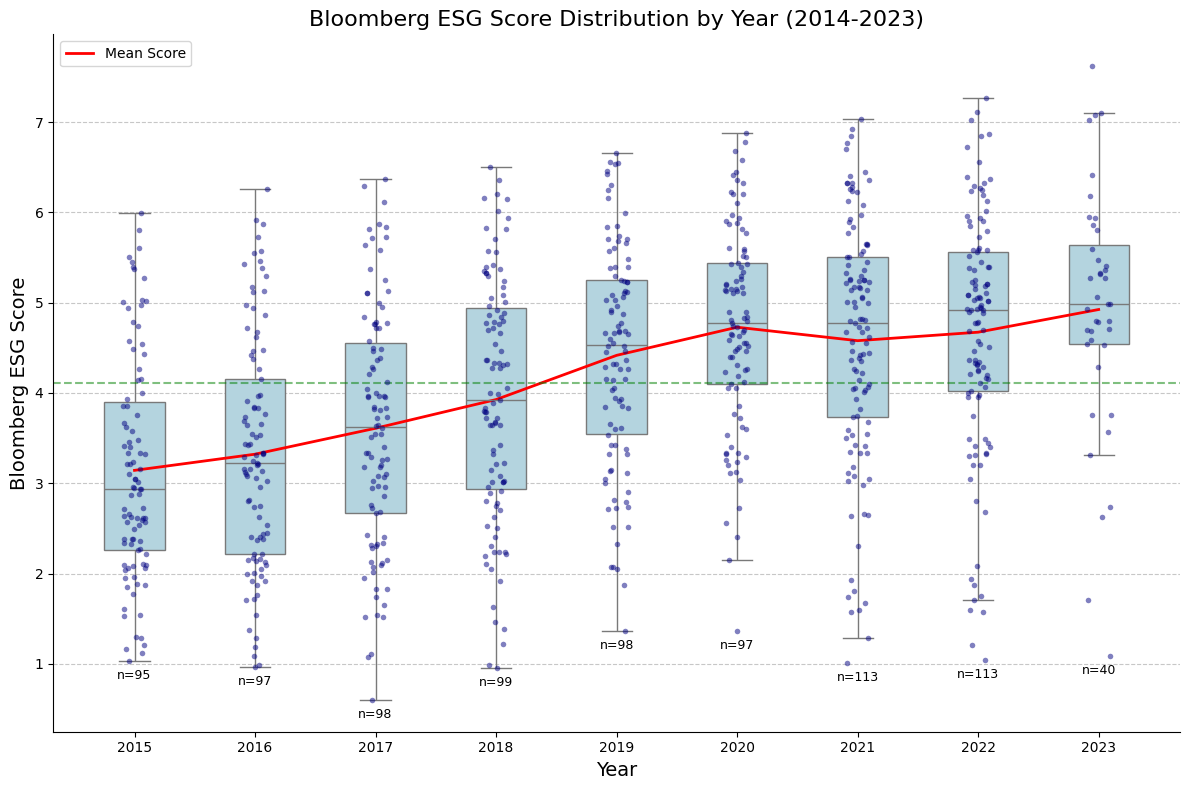

In [7]:
# Convert 'BESG ESG Score' to numeric, forcing errors to NaN
df['BESG ESG Score'] = pd.to_numeric(df['BESG ESG Score'], errors='coerce')

# Filter only rows with BESG ESG Score data
df_filtered = df.dropna(subset=['BESG ESG Score'])

# Drop rows with Years before 2014
df_filtered = df_filtered[df_filtered['Year'] >= 2015]

# Create a figure with appropriate size
plt.figure(figsize=(12, 8))

# Create the box plot without outliers
ax = sns.boxplot(x='Year', y='BESG ESG Score', data=df_filtered,
                 color='lightblue', width=0.5, showfliers=False)

# Add individual data points with jitter
sns.stripplot(x='Year', y='BESG ESG Score', data=df_filtered,
              size=4, color='navy', alpha=0.5, jitter=True)

# Add a trend line showing the mean score per year
means = df_filtered.groupby('Year')['BESG ESG Score'].mean()
plt.plot(range(len(means)), means.values, 'r-', linewidth=2, label='Mean Score')

# Enhance the plot with labels and title
plt.title('Bloomberg ESG Score Distribution by Year (2014-2023)', fontsize=16)
plt.xlabel('Year', fontsize=14)
plt.ylabel('Bloomberg ESG Score', fontsize=14)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.legend()

# Annotate with some key statistics
for i, year in enumerate(sorted(df_filtered['Year'].unique())):
    year_data = df_filtered[df_filtered['Year'] == year]['BESG ESG Score']
    if not year_data.empty:
        plt.annotate(f'n={len(year_data)}',
                    xy=(i, year_data.min() - 0.2),
                    ha='center', fontsize=9)

# Add a horizontal line at the overall mean
plt.axhline(y=df_filtered['BESG ESG Score'].mean(), color='green',
           linestyle='--', alpha=0.5, label='Overall Mean')

# Improve aesthetics
sns.despine(left=False, bottom=False)
plt.tight_layout()

# Show the plot
plt.show()

In [8]:
# Filter out Large Cap and Mega Cap companies and create a new DataFrame
df_large_cap = df_filtered[df_filtered['Market Cap Category'].isin(['Large Cap', 'Mega Cap'])]
df_large_cap.shape

(220, 141)

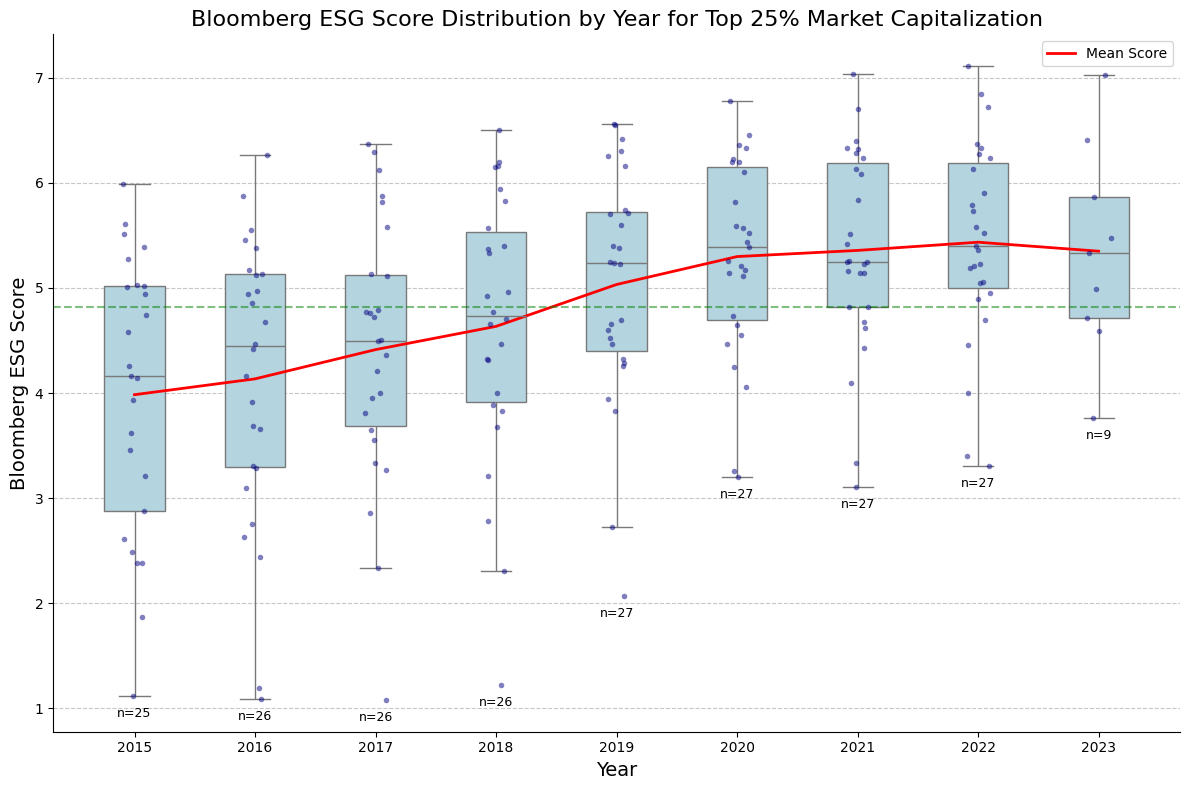

In [9]:
# Create a figure with appropriate size
plt.figure(figsize=(12, 8))

# Create the box plot without outliers
ax = sns.boxplot(x='Year', y='BESG ESG Score', data=df_large_cap,
                 color='lightblue', width=0.5, showfliers=False)

# Add individual data points with jitter
sns.stripplot(x='Year', y='BESG ESG Score', data=df_large_cap,
              size=4, color='navy', alpha=0.5, jitter=True)

# Add a trend line showing the mean score per year
means = df_large_cap.groupby('Year')['BESG ESG Score'].mean()
plt.plot(range(len(means)), means.values, 'r-', linewidth=2, label='Mean Score')

# Enhance the plot with labels and title
plt.title('Bloomberg ESG Score Distribution by Year for Top 25% Market Capitalization', fontsize=16)
plt.xlabel('Year', fontsize=14)
plt.ylabel('Bloomberg ESG Score', fontsize=14)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.legend()

# Annotate with some key statistics
for i, year in enumerate(sorted(df_large_cap['Year'].unique())):
    year_data = df_large_cap[df_large_cap['Year'] == year]['BESG ESG Score']
    if not year_data.empty:
        plt.annotate(f'n={len(year_data)}',
                    xy=(i, year_data.min() - 0.2),
                    ha='center', fontsize=9)

# Add a horizontal line at the overall mean
plt.axhline(y=df_large_cap['BESG ESG Score'].mean(), color='green',
           linestyle='--', alpha=0.5, label='Overall Mean')

# Improve aesthetics
sns.despine(left=False, bottom=False)
plt.tight_layout()

# Show the plot
plt.show()

#### Correlation Analysis

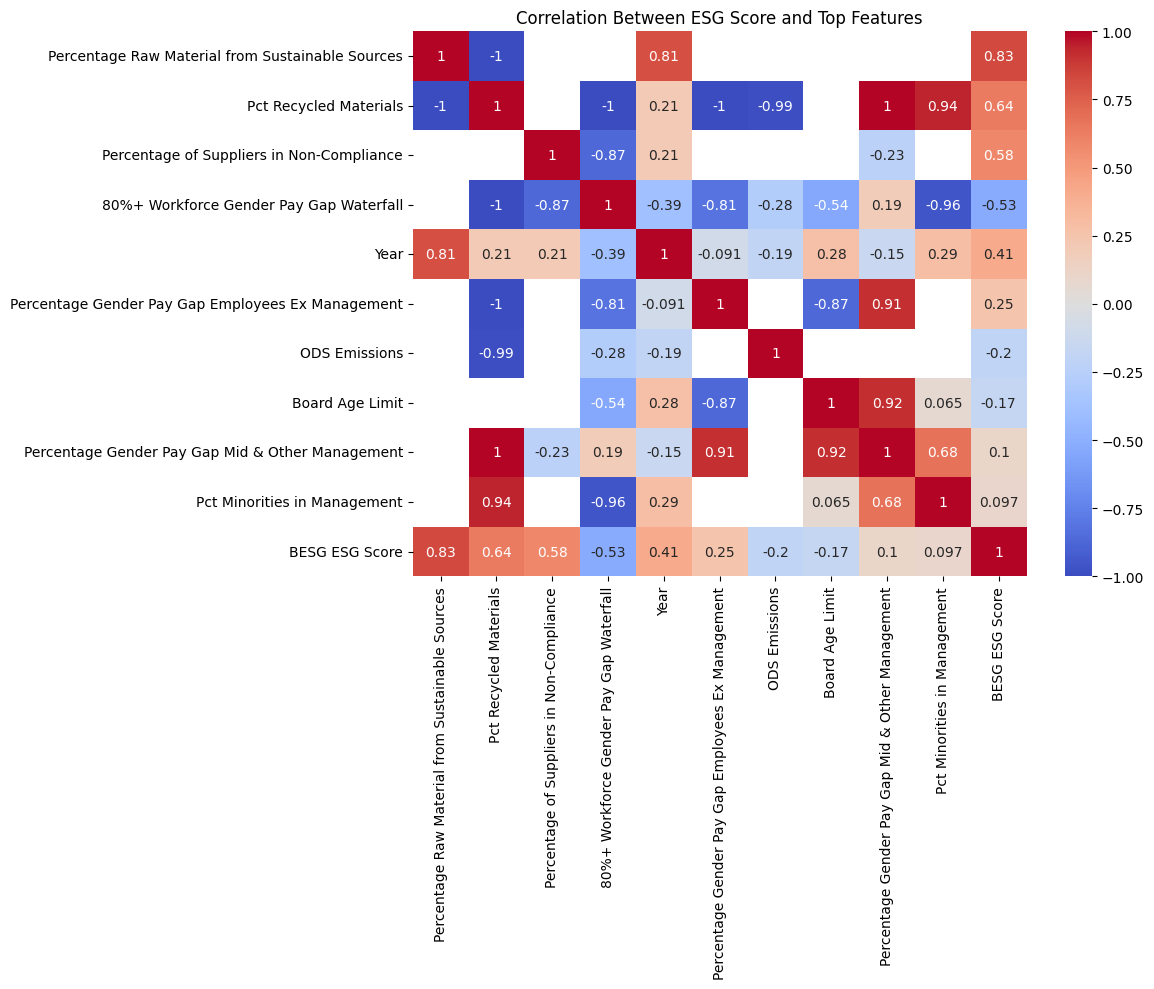

In [10]:
# Select numeric columns for correlation analysis
numeric_cols = df_filtered.select_dtypes(include=['float64', 'int64']).columns.tolist()

# Drop columns with ESG Pillar Scores
cols_to_drop = ['BESG Environmental Pillar Score',
            'BESG Social Pillar Score', 'BESG Governance Pillar Score']

numeric_cols = [col for col in numeric_cols if col not in cols_to_drop]

# Calculate correlation matrix
correlation_matrix = df_filtered[numeric_cols].corr()

# Plot correlation heatmap for ESG scores
esg_cols = ['BESG ESG Score']

# Find top correlated features with ESG scores
esg_correlations = correlation_matrix[esg_cols].drop(esg_cols)
top_correlations = {}

for col in esg_cols:
    # Get absolute correlations and sort
    abs_corr = esg_correlations[col].abs().sort_values(ascending=False)
    # Store top 10 correlated features
    top_correlations[col] = abs_corr.head(10)

# Plot heatmap of top correlations with overall ESG score
plt.figure(figsize=(12, 10))
top_features = top_correlations['BESG ESG Score'].index.tolist()
sns.heatmap(correlation_matrix.loc[top_features + ['BESG ESG Score'],
                                  top_features + ['BESG ESG Score']],
            annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation Between ESG Score and Top Features')
plt.tight_layout()

### 3. Regression Analysis

In [11]:
# Prepare data for modeling
df_filtered, cat_features, num_features = prepare_data_for_modeling(df_filtered)

print(f"Number of categorical features: {len(cat_features)}")
print(f"Number of numerical features: {len(num_features)}")

# Show sample of features
print("\nSample categorical features:", cat_features[:5])
print("Sample numerical features:", num_features[:5])

# cols_to_drop = ['Company', 'Ticker', 'Year', 'BESG Environmental Pillar Score', 'BESG Social Pillar Score', 'BESG Governance Pillar Score']

# Split the data into training, validation, and test sets
X = df_filtered[cat_features + num_features]

# Verify columns to drop are in the DataFrame
print(f"Columns before dropping: {X.columns.tolist()}")

# Drop the specified columns
# X = X.drop(cols_to_drop, axis=1)

# Verify columns after dropping
print(f"Columns after dropping: {X.columns.tolist()}")

# Update cat_features and num_features to exclude dropped columns
# cat_features = [col for col in cat_features if col not in cols_to_drop]
# num_features = [col for col in num_features if col not in cols_to_drop]

y = df_filtered['BESG ESG Score']

# First split: train+val vs test (80% vs 20%)
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Second split: train vs val (80% vs 20% of train_val, which is 64% vs 16% of the original data)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.2, random_state=42)

print(f"Training set size: {X_train.shape[0]}")
print(f"Validation set size: {X_val.shape[0]}")
print(f"Test set size: {X_test.shape[0]}")

Identified 129 categorical features
Identified 11 numerical features
Number of categorical features: 129
Number of numerical features: 11

Sample categorical features: ['Company', 'Ticker', 'BESG Environmental Pillar Score', 'BESG Social Pillar Score', 'BESG Governance Pillar Score']
Sample numerical features: ['Board Age Limit', '80%+ Workforce Gender Pay Gap Waterfall', 'Pct Minorities in Management', 'Percentage Gender Pay Gap for Senior Management', 'Percentage Gender Pay Gap Mid & Other Management']
Columns before dropping: ['Company', 'Ticker', 'BESG Environmental Pillar Score', 'BESG Social Pillar Score', 'BESG Governance Pillar Score', 'ESG Disclosure Score', 'Environmental Disclosure Score', 'Social Disclosure Score', 'Governance Disclosure Score', 'Nitrogen Oxide Emissions', 'VOC Emissions', 'Particulate Emissions', 'Sulphur Dioxide / Sulphur Oxide Emissions', 'Risks of Climate Change Discussed', 'GHG Scope 1', 'GHG Scope 2 Location-Based', 'GHG Scope 3', 'Carbon per Unit of 

In [12]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer

In [16]:
# Compare with a baseline model (e.g., Random Forest)
from sklearn.ensemble import RandomForestRegressor
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# Create a preprocessing pipeline
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, num_features),
        ('cat', categorical_transformer, cat_features)
    ])

# Create and train the Random Forest model
rf_model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', RandomForestRegressor(n_estimators=100, max_depth=15, random_state=42))
])

# Fit on training data
rf_model.fit(X_train, y_train)

# Make predictions
rf_predictions = rf_model.predict(X_test)

# Calculate evaluation metrics
rf_mse = mean_squared_error(y_test, rf_predictions)
rf_rmse = np.sqrt(rf_mse)
rf_mae = mean_absolute_error(y_test, rf_predictions)
rf_r2 = r2_score(y_test, rf_predictions)

print("Random Forest Performance:")
print(f"Mean Squared Error: {rf_mse:.4f}")
print(f"Root Mean Squared Error: {rf_rmse:.4f}")
print(f"Mean Absolute Error: {rf_mae:.4f}")
print(f"R-squared: {rf_r2:.4f}")

Random Forest Performance:
Mean Squared Error: 0.3388
Root Mean Squared Error: 0.5821
Mean Absolute Error: 0.4182
R-squared: 0.8510


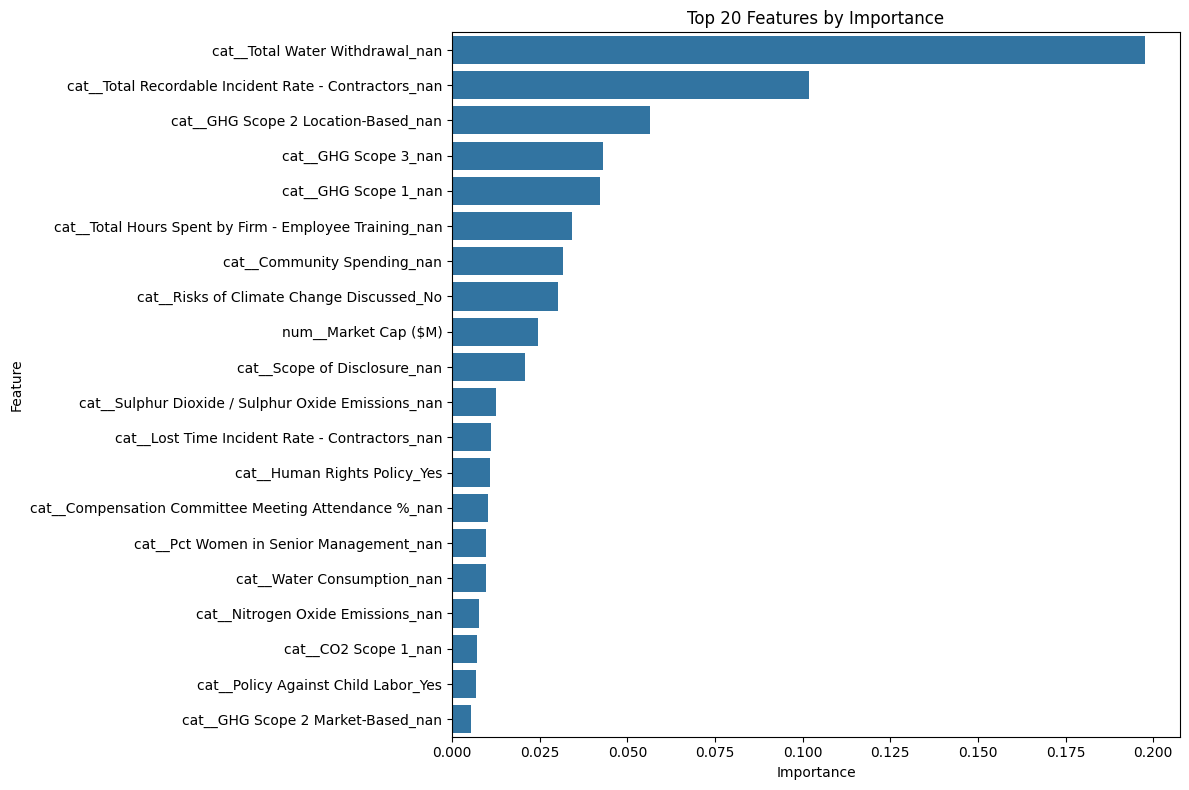

In [14]:
# Extract the trained RandomForestRegressor from the pipeline
rf_regressor = rf_model.named_steps['regressor']

# Get feature importances
importances = rf_regressor.feature_importances_

# Get feature names from the preprocessor
feature_names = rf_model.named_steps['preprocessor'].get_feature_names_out()

# Create a DataFrame for plotting
feature_importances = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
feature_importances = feature_importances.sort_values(by='Importance', ascending=False)

# Plot top 20 features by importance
plt.figure(figsize=(12, 8))
sns.barplot(x='Importance', y='Feature', data=feature_importances.head(20))
plt.title('Top 20 Features by Importance')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()

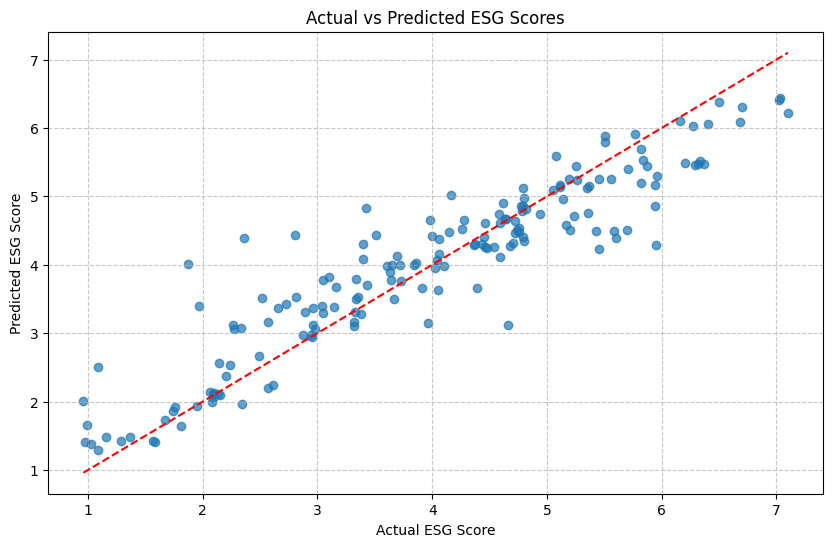

In [15]:
# Plot actual vs predicted values
plt.figure(figsize=(10, 6))
plt.scatter(y_test, rf_predictions, alpha=0.7)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel('Actual ESG Score')
plt.ylabel('Predicted ESG Score')
plt.title('Actual vs Predicted ESG Scores')
plt.grid(True, linestyle='--', alpha=0.7)